In [1]:
import time
import os


import numpy as np
import pandas as pd

import datetime as dt


from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,roc_auc_score
from sklearn import neighbors

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.gaussian_process import GaussianProcessClassifier

/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:

models = {
            'linear' : {
                    'mod' : LogisticRegression(solver = 'saga'),
                    'par' : {'penalty' : ('l1','l2','elasticnet','none'),
                                'C': [1,1.5,2],
                            'l1_ratio':[0.2,0.5,0.8]}
                    },                     
            'gradient' : {
                    'mod' : GradientBoostingClassifier(warm_start = True),
                    'par' : {'loss' : ('deviance', 'exponential'),
                             'max_depth' : [3, 4, 5, 6, 7]}
                        },
           'tree':{'mod': DecisionTreeClassifier(),
                     'par':{'splitter':('best','random'),
                            'max_depth': [None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}},
            'svm' : {
                    'mod' : svm.SVC(probability=True),
                    'par' : {'kernel' : ( 'linear', 'rbf')}
                    },
        'RandomForest' : {
                    'mod' : RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, criterion = 'gini'),
                    'par' : {'max_depth' :[None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}
                        },
        'Knn' : {
                    'mod' : neighbors.KNeighborsClassifier(),
                    'par' : {'n_neighbors' :[5, 10, 15],
                            'leaf_size':[15,25,30]}
                        },
        'GCP' : {
                    'mod' : GaussianProcessClassifier(),
                    'par' : {'optimizer' :['fmin_l_bfgs_b'],
                            }
                        }  
    
        }


In [3]:
def grid(x_name,n_proc, os_X_tt, os_Y_tt, X_test, y_test,  models, score = 'roc_auc', cv = 7):
    
    # Gridsearch
    
    result = dict()
    bestmodels = models.copy()
    for name in models:
        print('*'*80)
        print("Model: " + name)
        t_beg = time.time()

        pipeline = Pipeline([('scaler', StandardScaler()), (name,  bestmodels[name]['mod'])])          
        parameters = {}          
        for par in bestmodels[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = bestmodels[name]['par'][par]    
        aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc,\
                          scoring = score, verbose=2, cv = cv)
        aux.fit(os_X_tt, os_Y_tt)
        y_true, y_pred = y_test , aux.predict(X_test)
        
        #precision = precision_score(y_test, y_pred, average="macro")
        #recall = recall_score(y_test, y_pred, average="macro")  
        auc = roc_auc_score(y_test, y_pred, average="macro")
        #f1score = f1_score(y_test, y_pred, average="macro")
        accuracy = accuracy_score(y_test, y_pred)
        
        bestmodels[name]['bestModel'] = aux.best_estimator_
        bestmodels[name][score] = aux.best_score_
        bestmodels[name]['cols_order'] = os_X_tt.columns.values
        selection_time = time.time() - t_beg

        bestmodels[name]['selection_time'] = selection_time

        sample_f_path = f'modelos/{x_name}' + f'{name}_{dt.datetime.now().strftime("%Y%m%d-%H%M")}.sav'

        print(f"Saving model at {sample_f_path}")    
        joblib.dump(bestmodels[name]['bestModel'], sample_f_path)

        print(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        print(f"El error {score} de la familia {name} es: {bestmodels[name][score]:0.3f}")
        print('*'*80)
    
        #result[name] = {"auc": round(auc,3), "precision": round(precision,3), "recall": round(recall,3),"f1score": round(f1score,3)}
        result[name] = {"auc": round(auc,3), "accuracy": round(accuracy,3)}
        
    mod_name = None
    best_mae = -np.inf
    for name in models:
        if bestmodels[name][score] > best_mae:
            mod_name = name
            best_mae = bestmodels[name][score]

    print(f"best model: " + mod_name + f" with an error {score} of: " + str(best_mae))
    
    return bestmodels, result

In [4]:
#Bestmodels

def get_max(dictionary, key_val):
    auc_list = []
    auc_dict = {}

    for key in dictionary:
        for key2 in dictionary[key]:
            if key_val in key2:
                auc_list.append(dictionary[key][key_val])

    max_key = ''
    max_val = max(auc_list)

    for key in dictionary:
        for key2 in dictionary[key]:
            if max_val == dictionary[key][key_val]:
                max_key = key
                
    return max_key, max_val

# 1. Lectura de los datos

In [5]:
path = 'databinarystudents.csv'
data = pd.read_csv(path, sep = ',', na_filter = False)
data = data.set_index('id')

In [6]:
# variables seleccionadas según diferentes criterios
y = data[['yL']].copy()
X = data.drop(columns = ['yL']).copy()

In [7]:
# Definición del tamaño del test
test_size = 0.3

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [9]:
# variables con probabilidad de selección mayor al 55%
X1_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()
X1_test = X_test[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()

# variables con probabilidad de selección mayor al 60%
X2_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X2_test= X_test[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 65%
X3_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X3_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 70%
X4_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()
X4_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()

# variables con probabilidad de selección mayor al 80%
X5_train= X_train[['x1','x10','x12','x17','x23']].copy()
X5_test= X_test[['x1','x10','x12','x17','x23']].copy()

In [10]:
Bestmodels_X1, result_X1  = grid('X1', -1, X1_train, y_train.values, X1_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.5s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)

Saving model at modelos/X1linear_20191010-2116.sav
El tiempo de seleccion fue: 1.569 s
El error roc_auc de la familia linear es: 0.785
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn

Saving model at modelos/X1gradient_20191010-2116.sav
El tiempo de seleccion fue: 0.493 s
El error roc_auc de la familia gradient es: 0.733
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X1tree_20191010-2116.sav
El tiempo de seleccion fue: 0.160 s
El error roc_auc de la familia tree es: 0.742
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X1svm_20191010-2116.sav
El tiempo de seleccion fue: 0.031 s
El error roc_auc de la familia svm es: 0.800
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Saving model at modelos/X1RandomForest_20191010-2116.sav
El tiempo de seleccion fue: 1.031 s
El error roc_auc de la familia RandomForest es: 0.762
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X1Knn_20191010-2116.sav
El tiempo de seleccion fue: 0.094 s
El error roc_auc de la familia Knn es: 0.767
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X1GCP_20191010-2116.sav
El tiempo de seleccion fue: 0.050 s
El error roc_auc de la familia GCP es: 0.738
********************************************************************************
best model: svm with an error roc_auc of: 0.79959

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/mo

<IPython.core.display.Javascript object>


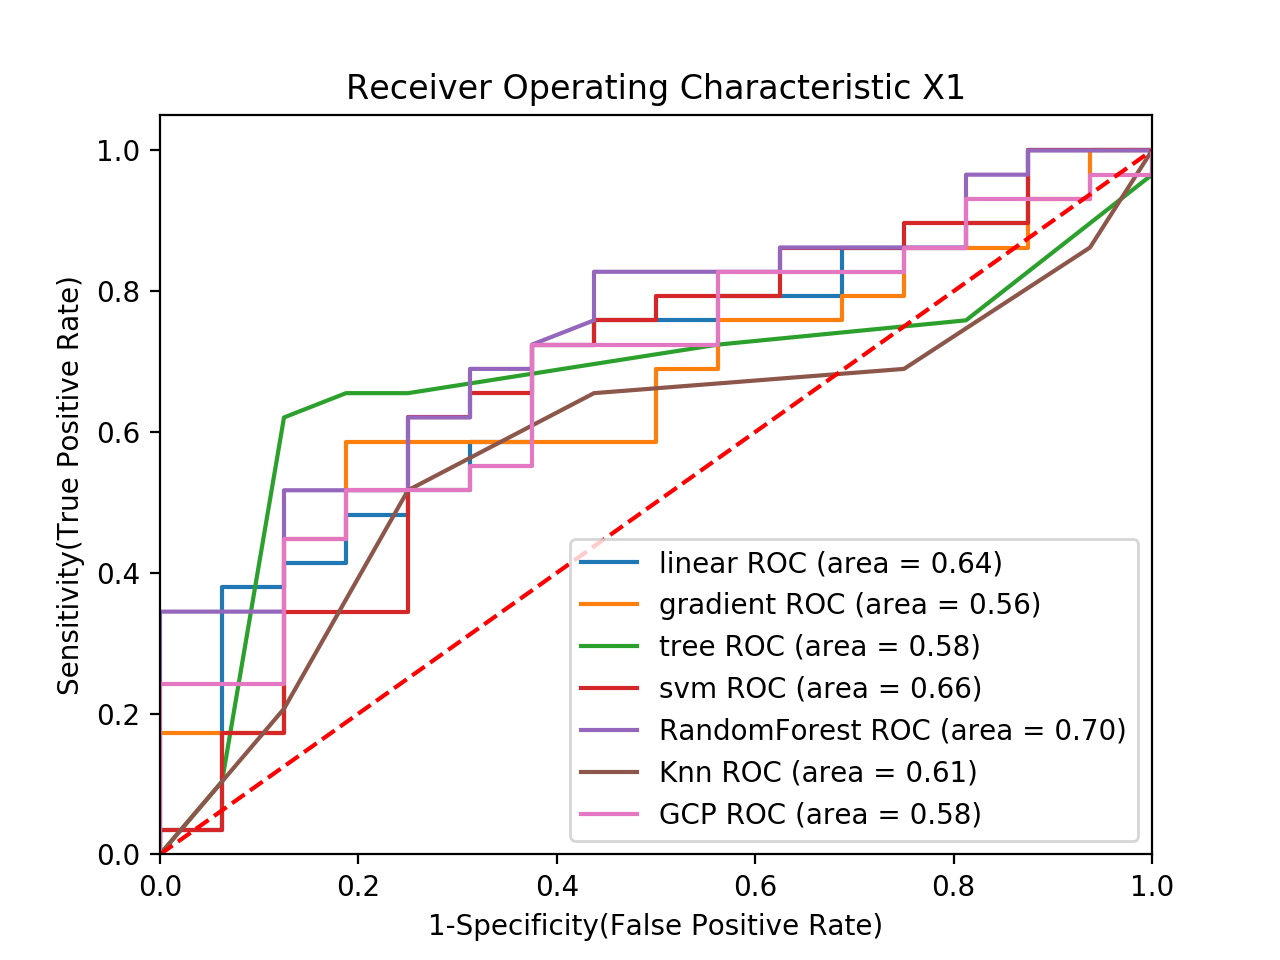

In [11]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X1:
    model =Bestmodels_X1[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X1_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X1')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X1.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [14]:
Bestmodels_X2, result_X2  = grid('X2', -1, X2_train, y_train.values, X2_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1

Saving model at modelos/X2linear_20191010-2116.sav
El tiempo de seleccion fue: 0.334 s
El error roc_auc de la familia linear es: 0.763
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   

Saving model at modelos/X2gradient_20191010-2116.sav
El tiempo de seleccion fue: 0.516 s
El error roc_auc de la familia gradient es: 0.667
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X2tree_20191010-2116.sav
El tiempo de seleccion fue: 0.135 s
El error roc_auc de la familia tree es: 0.732
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X2svm_20191010-2116.sav
El tiempo de seleccion fue: 0.030 s
El error roc_auc de la familia svm es: 0.777
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:81

Saving model at modelos/X2RandomForest_20191010-2116.sav
El tiempo de seleccion fue: 1.088 s
El error roc_auc de la familia RandomForest es: 0.707
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X2Knn_20191010-2116.sav
El tiempo de seleccion fue: 0.097 s
El error roc_auc de la familia Knn es: 0.734
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X2GCP_20191010-2116.sav
El tiempo de seleccion fue: 0.045 s
El error roc_auc de la familia GCP es: 0.699
********************************************************************************
best model: svm with an error roc_auc of: 0.77718

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/mo

In [15]:
coef_beta = Bestmodels_X2['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X2 = Bestmodels_X2['linear']['cols_order'].tolist()

In [16]:
coef_beta[0][0]

0.3393162377095227

In [17]:
for i in range(len(var_X2)):
    print(var_X2[i] +': '+ str(coef_beta[0][i]))

x1: 0.3393162377095227
x2: 0.0
x3: -0.5485498888801996
x4: -0.32692946016319546
x10: 0.08597373933408771
x11: 0.0
x12: -0.3157039880173142
x17: -0.43862851945115533
x21: 0.12088886057750252
x23: 1.015674729089831
x25: -0.10760940918763955
x27: 0.16484601787086517


<IPython.core.display.Javascript object>


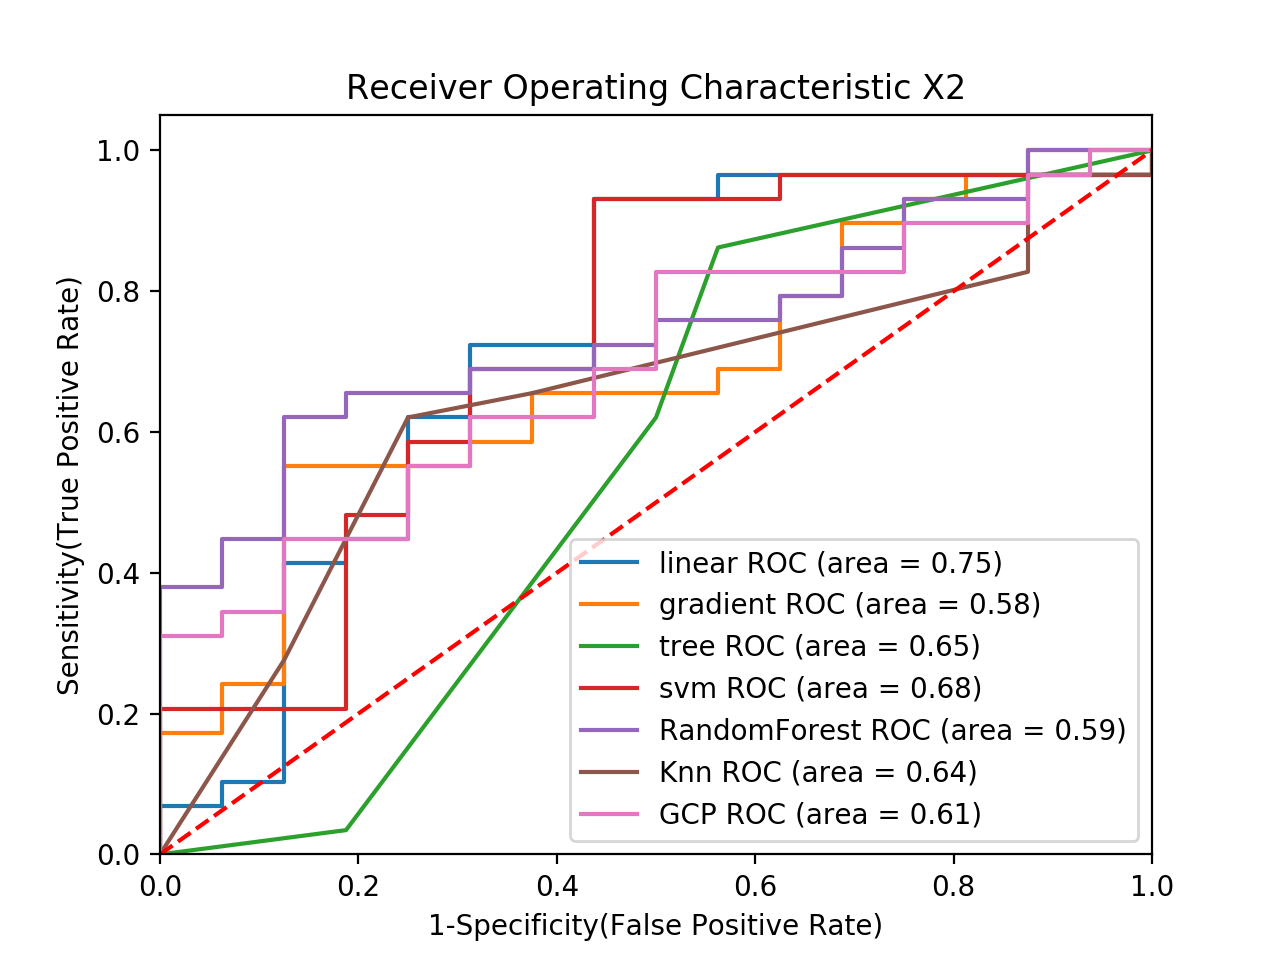

In [18]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X2:
    model =Bestmodels_X2[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X2_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X2_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X2')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X2.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [19]:
Bestmodels_X3, result_X3  = grid('X3', -1, X3_train, y_train.values, X3_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/pyt

Saving model at modelos/X3linear_20191010-2116.sav
El tiempo de seleccion fue: 0.336 s
El error roc_auc de la familia linear es: 0.724
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_s

Saving model at modelos/X3gradient_20191010-2116.sav
El tiempo de seleccion fue: 0.661 s
El error roc_auc de la familia gradient es: 0.673
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X3tree_20191010-2116.sav
El tiempo de seleccion fue: 0.147 s
El error roc_auc de la familia tree es: 0.688
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X3svm_20191010-2116.sav
El tiempo de seleccion fue: 0.036 s
El error roc_auc de la familia svm es: 0.684
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  29 out of  60 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remai

Saving model at modelos/X3RandomForest_20191010-2116.sav
El tiempo de seleccion fue: 0.990 s
El error roc_auc de la familia RandomForest es: 0.680
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X3Knn_20191010-2116.sav
El tiempo de seleccion fue: 0.127 s
El error roc_auc de la familia Knn es: 0.693
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X3GCP_20191010-2116.sav
El tiempo de seleccion fue: 0.051 s
El error roc_auc de la familia GCP es: 0.619
********************************************************************************
best model: linear with an error roc_auc of: 0.72

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_

<IPython.core.display.Javascript object>


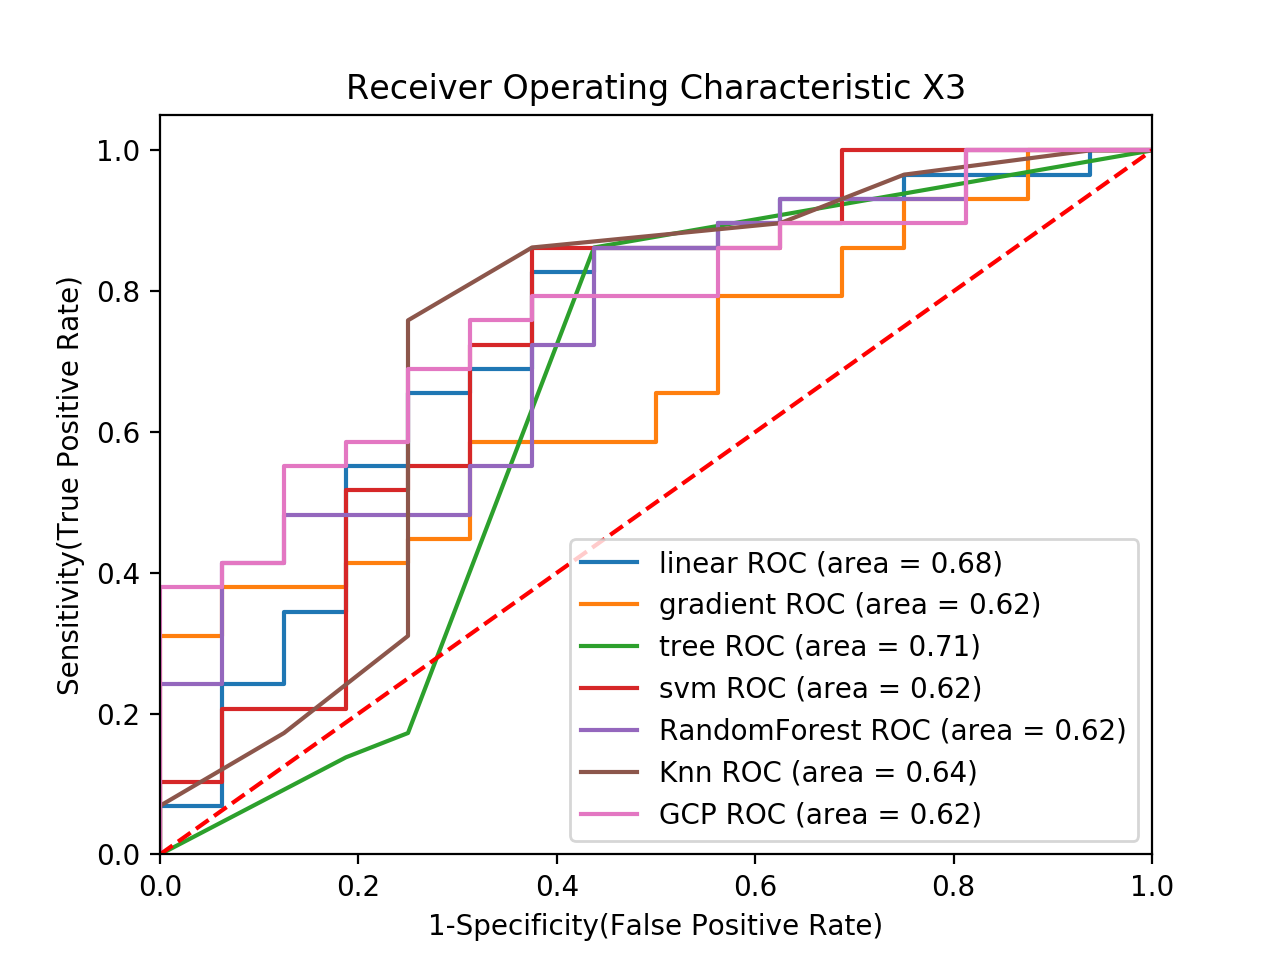

In [20]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X3:
    model =Bestmodels_X3[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X3_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X3_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X3')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X3.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [21]:
Bestmodels_X4, result_X4  = grid('X4', -1, X4_train, y_train.values, X4_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1

Saving model at modelos/X4linear_20191010-2116.sav
El tiempo de seleccion fue: 0.303 s
El error roc_auc de la familia linear es: 0.729
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.4s


Saving model at modelos/X4gradient_20191010-2116.sav
El tiempo de seleccion fue: 0.658 s
El error roc_auc de la familia gradient es: 0.692
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X4tree_20191010-2116.sav
El tiempo de seleccion fue: 0.171 s
El error roc_auc de la familia tree es: 0.728
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

Saving model at modelos/X4svm_20191010-2116.sav
El tiempo de seleccion fue: 0.053 s
El error roc_auc de la familia svm es: 0.702
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Saving model at modelos/X4RandomForest_20191010-2116.sav
El tiempo de seleccion fue: 1.127 s
El error roc_auc de la familia RandomForest es: 0.708
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X4Knn_20191010-2116.sav
El tiempo de seleccion fue: 0.122 s
El error roc_auc de la familia Knn es: 0.712
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X4GCP_20191010-2116.sav
El tiempo de seleccion fue: 0.046 s
El error roc_auc de la familia GCP es: 0.643
********************************************************************************
best model: linear with an error roc_auc of: 0.72

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parame

<IPython.core.display.Javascript object>


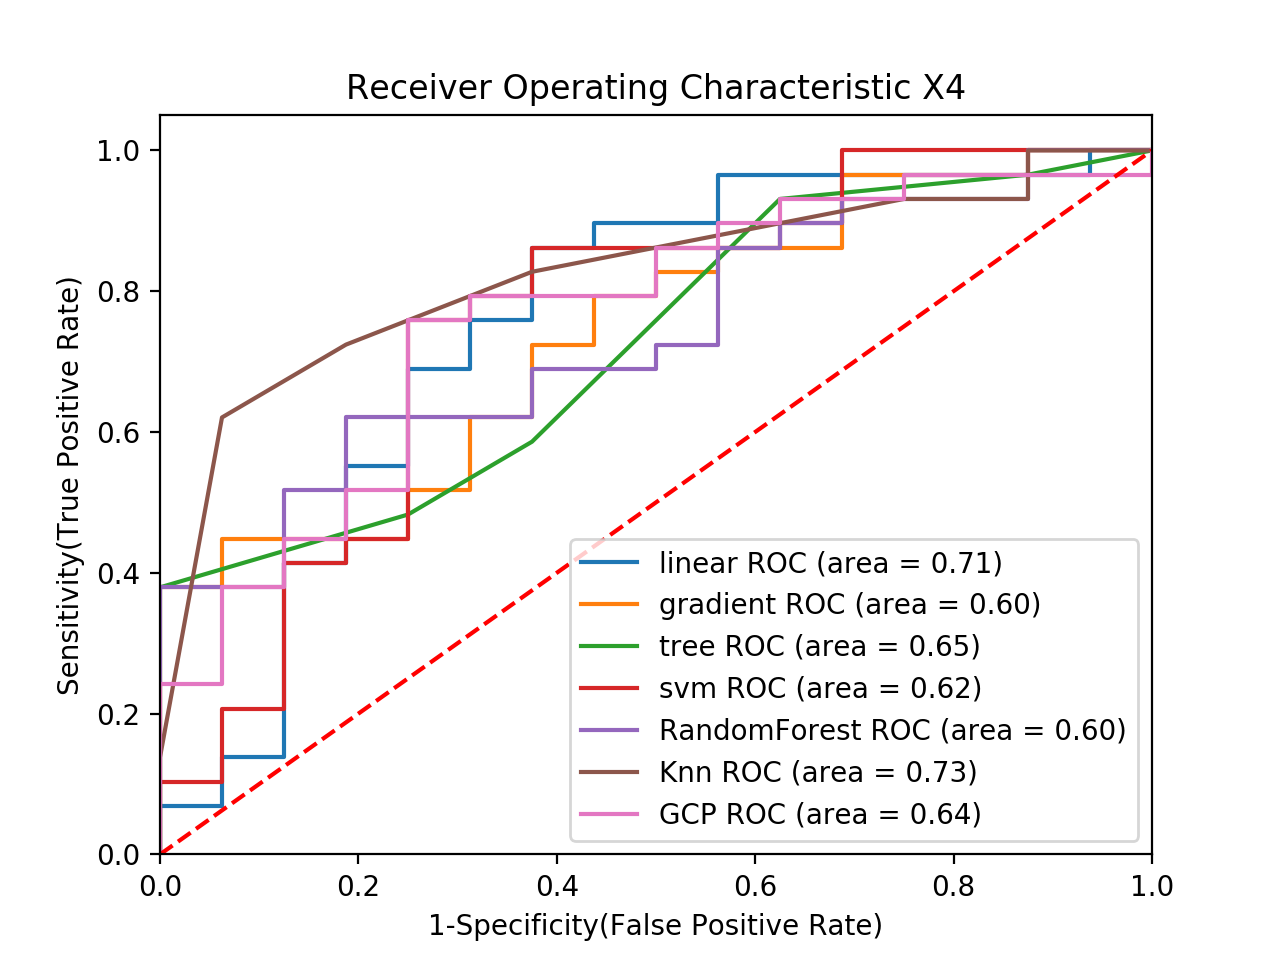

In [22]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X4:
    model =Bestmodels_X4[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X4_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X4_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X4')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X4.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [23]:
Bestmodels_X5, result_X5  = grid('X5', -1, X5_train, y_train.values, X5_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    0.2s remaining:    0.3s


Saving model at modelos/X5linear_20191010-2117.sav
El tiempo de seleccion fue: 0.286 s
El error roc_auc de la familia linear es: 0.760
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_s

Saving model at modelos/X5gradient_20191010-2117.sav
El tiempo de seleccion fue: 0.650 s
El error roc_auc de la familia gradient es: 0.715
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X5tree_20191010-2117.sav
El tiempo de seleccion fue: 0.139 s
El error roc_auc de la familia tree es: 0.732
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X5svm_20191010-2117.sav
El tiempo de seleccion fue: 0.034 s
El error roc_auc de la familia svm es: 0.745
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:81

Saving model at modelos/X5RandomForest_20191010-2117.sav
El tiempo de seleccion fue: 1.137 s
El error roc_auc de la familia RandomForest es: 0.699
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X5Knn_20191010-2117.sav
El tiempo de seleccion fue: 0.122 s
El error roc_auc de la familia Knn es: 0.763
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X5GCP_20191010-2117.sav
El tiempo de seleccion fue: 0.057 s
El error roc_auc de la familia GCP es: 0.696
********************************************************************************
best model: Knn with an error roc_auc of: 0.76292

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_

In [24]:
Bestmodels_X5['linear']['bestModel']

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.8, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

<IPython.core.display.Javascript object>


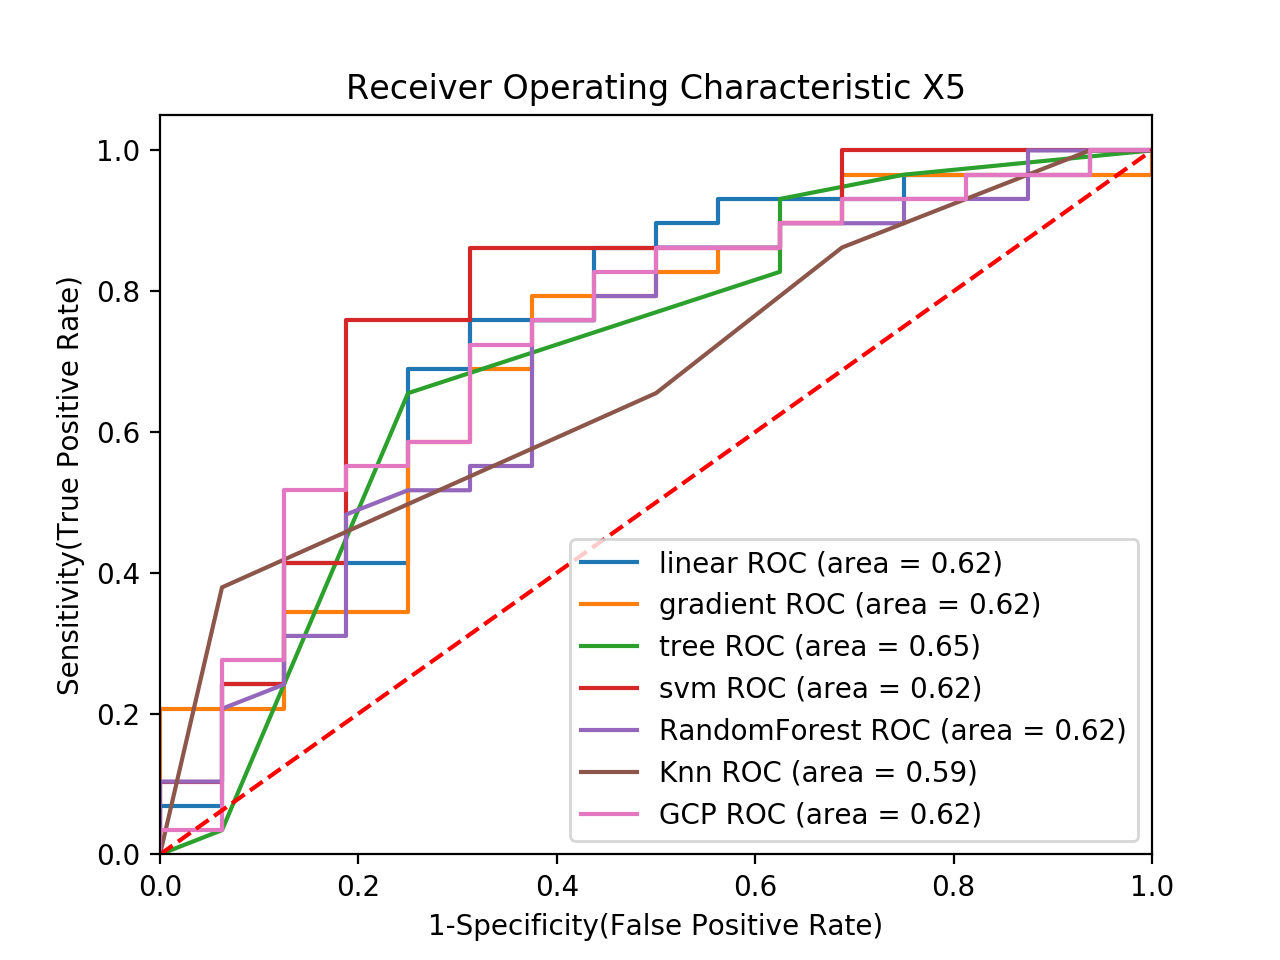

In [25]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [26]:
coef_beta = Bestmodels_X5['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X5 = Bestmodels_X5['linear']['cols_order'].tolist()
for i in range(len(var_X5)):
    print(var_X5[i] +': '+ str(coef_beta[0][i]))

x1: 0.43418202298240155
x10: 0.09344576276598263
x12: -0.35187427882946254
x17: -0.5562944591170699
x23: 0.8810440828050793


<IPython.core.display.Javascript object>


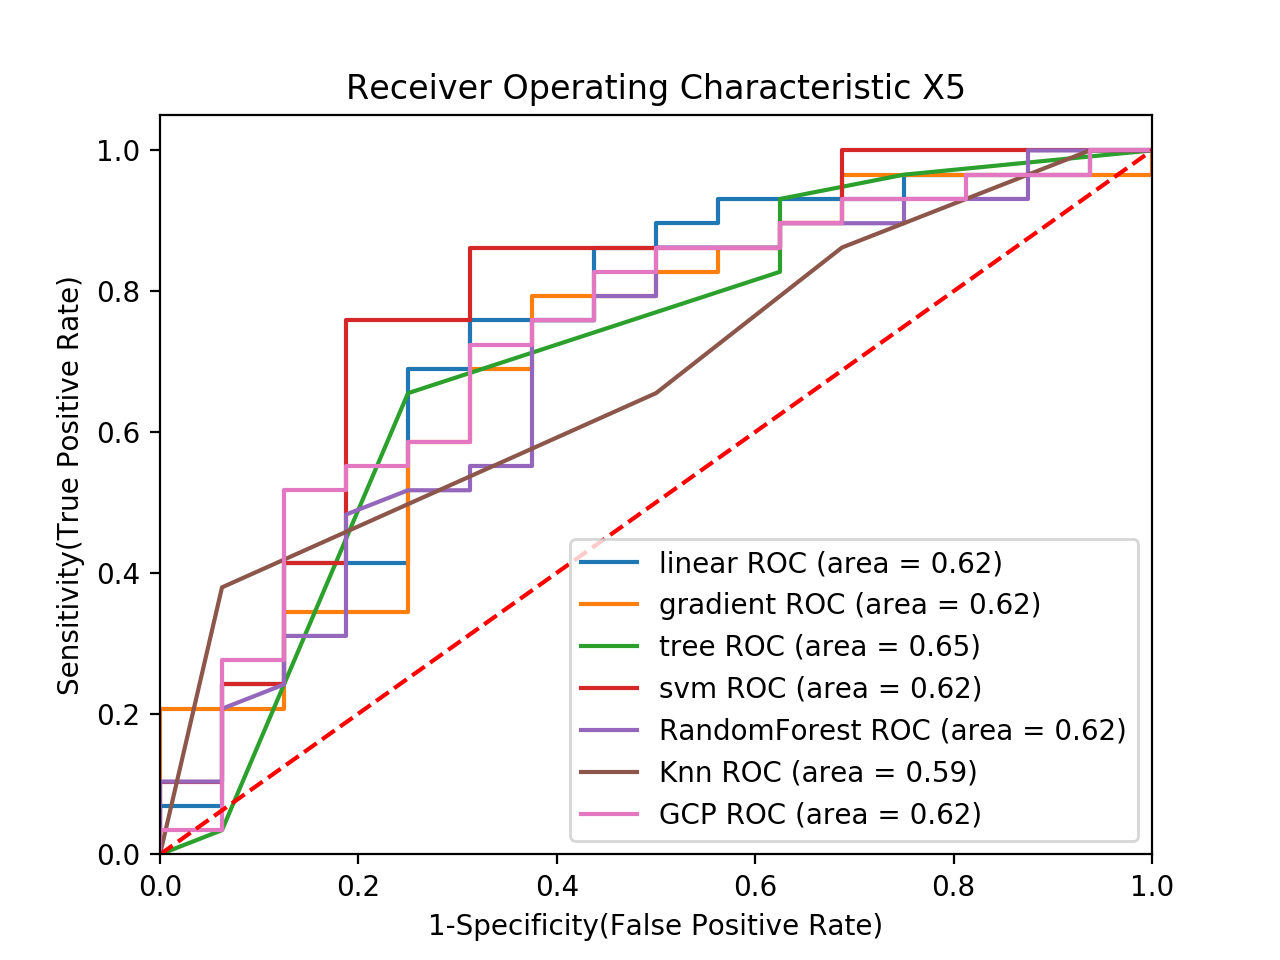

In [27]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [28]:
result_X1

{'linear': {'auc': 0.643, 'accuracy': 0.667},
 'gradient': {'auc': 0.564, 'accuracy': 0.6},
 'tree': {'auc': 0.581, 'accuracy': 0.622},
 'svm': {'auc': 0.661, 'accuracy': 0.689},
 'RandomForest': {'auc': 0.695, 'accuracy': 0.733},
 'Knn': {'auc': 0.609, 'accuracy': 0.622},
 'GCP': {'auc': 0.581, 'accuracy': 0.622}}

In [29]:
result_X2

{'linear': {'auc': 0.747, 'accuracy': 0.8},
 'gradient': {'auc': 0.584, 'accuracy': 0.644},
 'tree': {'auc': 0.65, 'accuracy': 0.711},
 'svm': {'auc': 0.684, 'accuracy': 0.756},
 'RandomForest': {'auc': 0.587, 'accuracy': 0.667},
 'Knn': {'auc': 0.64, 'accuracy': 0.644},
 'GCP': {'auc': 0.609, 'accuracy': 0.622}}

In [30]:
result_X3

{'linear': {'auc': 0.681, 'accuracy': 0.733},
 'gradient': {'auc': 0.615, 'accuracy': 0.667},
 'tree': {'auc': 0.712, 'accuracy': 0.756},
 'svm': {'auc': 0.619, 'accuracy': 0.689},
 'RandomForest': {'auc': 0.622, 'accuracy': 0.711},
 'Knn': {'auc': 0.636, 'accuracy': 0.711},
 'GCP': {'auc': 0.619, 'accuracy': 0.689}}

In [31]:
result_X4

{'linear': {'auc': 0.712, 'accuracy': 0.756},
 'gradient': {'auc': 0.605, 'accuracy': 0.689},
 'tree': {'auc': 0.653, 'accuracy': 0.733},
 'svm': {'auc': 0.619, 'accuracy': 0.689},
 'RandomForest': {'auc': 0.605, 'accuracy': 0.689},
 'Knn': {'auc': 0.726, 'accuracy': 0.756},
 'GCP': {'auc': 0.636, 'accuracy': 0.711}}

In [32]:
result_X5

{'linear': {'auc': 0.622, 'accuracy': 0.711},
 'gradient': {'auc': 0.619, 'accuracy': 0.689},
 'tree': {'auc': 0.653, 'accuracy': 0.733},
 'svm': {'auc': 0.619, 'accuracy': 0.689},
 'RandomForest': {'auc': 0.619, 'accuracy': 0.689},
 'Knn': {'auc': 0.587, 'accuracy': 0.667},
 'GCP': {'auc': 0.622, 'accuracy': 0.711}}

In [33]:
# Forma en que vas a llamar la función
resultado = get_max(result_X1, 'auc')
best_X1 = {}
best_X1[resultado[0]] = resultado[1]
print('BestX1: ' + str(best_X1))


resultado = get_max(result_X2, 'auc')
best_X2 = {}
best_X2[resultado[0]] = resultado[1]
print('BestX2: ' + str(best_X2))

resultado = get_max(result_X3, 'auc')
best_X3 = {}
best_X3[resultado[0]] = resultado[1]
print('BestX3: ' + str(best_X3))


resultado = get_max(result_X4, 'auc')
best_X4 = {}
best_X4[resultado[0]] = resultado[1]
print('BestX4: ' + str(best_X4))


resultado = get_max(result_X5, 'auc')
best_X5 = {}
best_X5[resultado[0]] = resultado[1]
print('BestX5: ' + str(best_X5))

BestX1: {'RandomForest': 0.695}
BestX2: {'linear': 0.747}
BestX3: {'tree': 0.712}
BestX4: {'Knn': 0.726}
BestX5: {'tree': 0.653}


In [34]:
# Mejor Modelo según accuracy
resultado = get_max(result_X1, 'accuracy')
best_X1 = {}
best_X1[resultado[0]] = resultado[1]
print('BestX1: ' + str(best_X1))


resultado = get_max(result_X2, 'accuracy')
best_X2 = {}
best_X2[resultado[0]] = resultado[1]
print('BestX2: ' + str(best_X2))

resultado = get_max(result_X3, 'accuracy')
best_X3 = {}
best_X3[resultado[0]] = resultado[1]
print('BestX3: ' + str(best_X3))


resultado = get_max(result_X4, 'accuracy')
best_X4 = {}
best_X4[resultado[0]] = resultado[1]
print('BestX4: ' + str(best_X4))


resultado = get_max(result_X5, 'accuracy')
best_X5 = {}
best_X5[resultado[0]] = resultado[1]
print('BestX5: ' + str(best_X5))

BestX1: {'RandomForest': 0.733}
BestX2: {'linear': 0.8}
BestX3: {'tree': 0.756}
BestX4: {'Knn': 0.756}
BestX5: {'tree': 0.733}


In [40]:
Selected_model = Bestmodels_X5['linear']
Bestmodels_X5['linear']

{'mod': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'par': {'penalty': ('l1', 'l2', 'elasticnet', 'none'),
  'C': [1, 1.5, 2],
  'l1_ratio': [0.2, 0.5, 0.8]},
 'bestModel': Pipeline(memory=None,
          steps=[('scaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('linear',
                  LogisticRegression(C=2, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=0.8, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='elasticnet', random_state=None,
                     

In [539]:
import pickle 
pickle.dump(Selected_model, open('modelBinary.sav', 'wb'))